This example shows an Updated Lagrangian formulation based on 8-node quadrilateral elements. A point force in vertical direction is applied to the right tip of the beam, createing bending-type large displacements. The Saint Venant–Kirchhoff model is used with the assumption of large displacements with small strains.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import meshio
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import spsolve
from scipy.linalg import solve
from scipy.sparse.linalg import eigsh
from scipy.sparse import dok_matrix


# ====================== Element Class ======================
class Element8node2D:
    def H(self, r, s):        
        return self.quadraticElements(r, s)
        
    def dhdR(self, r, s):
        # dN/dr
        dhdr = np.array([
            (1 - s) * (2*r + s) / 4,          # N1,r
            (1 - s) * (2*r - s) / 4,          # N2,r
            (1 + s) * (2*r + s) / 4,          # N3,r
            (1 + s) * (2*r - s) / 4,          # N4,r
            -r * (1 - s),                     # N5,r
            (1 - s**2) / 2,                   # N6,r
            -r * (1 + s),                     # N7,r
            -(1 - s**2) / 2                   # N8,r
        ])

        # dN/ds
        dhds = np.array([
            (1 - r) * (r + 2*s) / 4,          # N1,s
            (1 + r) * (2*s - r) / 4,          # N2,s
            (1 + r) * (r + 2*s) / 4,          # N3,s
            (1 - r) * (2*s - r) / 4,          # N4,s
            -(1 - r**2) / 2,                  # N5,s
            -s * (1 + r),                     # N6,s
            (1 - r**2) / 2,                   # N7,s
            -s * (1 - r)                      # N8,s
        ])

        return np.array([dhdr, dhds])

    def quadraticElements(self,r, s):
        return np.array([
            -(1 - s) * (1 - r) * (1 + r + s) / 4,
            -(1 - s) * (1 + r) * (1 - r + s) / 4,
            -(1 + s) * (1 + r) * (1 - r - s) / 4,
            -(1 + s) * (1 - r) * (1 + r - s) / 4,
            (1 - s) * (1 - r) * (1 + r) / 2,
            (1 + r) * (1 - s) * (1 + s) / 2,
            (1 + s) * (1 - r) * (1 + r) / 2,
            (1 - r) * (1 - s) * (1 + s) / 2
        ])

# ====================== Problem Setup ======================
mesh = meshio.read("SlenderBeamBendingExample.msh")
nodes = mesh.points
elements = mesh.cells_dict["quad8"]
E, nu, rho = 8, 0.3, 7800 
C = E / (1 - nu**2) * np.array([[1, nu, 0], [nu, 1, 0], [0, 0, (1 - nu) / 2]])
P0 = 2e-4

GQ_K_x, GQ_K_w = np.polynomial.legendre.leggauss(5)

numN = nodes.shape[0]
numE = elements.shape[0]
ndofs_per_dimension = numN
total_dofs = 2 * ndofs_per_dimension

element_model = Element8node2D()

# ====================== Boundary Conditions ======================
# Step 1: Find nodes on the bottom edge (y == 0)
BC_fix_xdir = np.where(nodes[:, 1] == 0)[0]
# Step 2: Y-direction constraints (offset by ndofs_per_dimension)
BC_fix_ydir = BC_fix_xdir + ndofs_per_dimension
# Step 3: Combine and sort unique constraints
BC_constrained = np.unique(np.concatenate([BC_fix_xdir, BC_fix_ydir]))
# Step 4: Get free DOFs
BC_free = np.setdiff1d(np.arange(0, total_dofs), BC_constrained)

# Find the node with maximum x and maximum y (tip corner)
tip = np.where((nodes[:, 0] == nodes[:, 0].max()) & (nodes[:, 1] == nodes[:, 1].max()))[0][0]

# ====================== Newton-Rhapson Iterations ======================
nodes_updated = nodes.copy()
hori = []
R  = np.zeros((total_dofs, 1))
for outer_iter in range(100):
    R[tip + ndofs_per_dimension] = -outer_iter/10 * P0
    for inner_iter in range(100):
        row_idx, col_idx, data_val_K, data_val_M = [], [], [], []
        F = np.zeros((total_dofs, 1))
        for elem_node_indices in elements:
            phi = np.array(elem_node_indices)
            
            Ke = np.zeros((16, 16))
            Fe = np.zeros((16, 1))

            # ----- Stiffness Matrix Integration -----
            for j, r in enumerate(GQ_K_x):
                for k, s in enumerate(GQ_K_x):

                    J = element_model.dhdR(r, s) @ nodes_updated[elem_node_indices, :2]
                    HrHs = element_model.dhdR(r, s)     # Shape: (2, 16)
                    HxHy = np.linalg.solve(J, HrHs)     # Shape: (2, 16)
                    Hx, Hy = HxHy[0], HxHy[1]           # Extract rows
                    Hx = Hx.reshape(1, -1)
                    Hy = Hy.reshape(1, -1)

                    # Almansi strain and Cauchy stress
                    U = nodes_updated[:, :2].flatten(order='F').reshape(-1, 1) - nodes[:, :2].flatten(order='F').reshape(-1, 1)
                    epsA11 = Hx @ U[phi] - 0.5 * (Hx @ U[phi])**2 - 0.5 * (Hx @ U[phi + ndofs_per_dimension])**2
                    epsA22 = Hy @ U[phi + ndofs_per_dimension] - 0.5 * (Hy @ U[phi])**2 - 0.5 * (Hy @ U[phi + ndofs_per_dimension])**2
                    epsA12 = 0.5 * ( Hy @ U[phi] 
                                   + Hx @ U[phi + ndofs_per_dimension] 
                                   - Hx @ U[phi] * Hy @ U[phi] 
                                   - Hx @ U[phi + ndofs_per_dimension] * Hy @ U[phi + ndofs_per_dimension])
                    tau = C @ np.concatenate([epsA11, epsA22, 2*epsA12]) # No initial-to-current transformation for C given small strain assumption

                    # K_linear
                    B_L = np.block([
                        [Hx, np.zeros((1, 8))],
                        [np.zeros((1, 8)), Hy],
                        [Hy, Hx]
                    ])
                    K_L = B_L.T @ C @ B_L

                    # K_nonlinear
                    K_NL11 = np.block([
                        [Hx.T * tau[0] @ Hx, np.zeros((8, 8))],
                        [np.zeros((8, 8)), Hx.T * tau[0] @ Hx]
                        ])
                    K_NL22 = np.block([
                        [Hy.T * tau[1] @ Hy, np.zeros((8, 8))],
                        [np.zeros((8, 8)), Hy.T * tau[1] @ Hy]
                        ])
                    K_NL12 = np.block([
                        [Hy.T * tau[2] @ Hx + Hx.T * tau[2] @ Hy, np.zeros((8, 8))],
                        [np.zeros((8, 8)), Hy.T * tau[2] @ Hx + Hx.T * tau[2] @ Hy]
                    ])
                    K_NL = K_NL11 + K_NL22 + K_NL12

                    Ke += (K_L + K_NL) * np.linalg.det(J) * GQ_K_w[j] * GQ_K_w[k]
                    Fe += B_L.T @ tau * np.linalg.det(J) * GQ_K_w[j] * GQ_K_w[k]

            # ----- Collect Stiffness Matrices -----
            for i in range(16):
                for j in range(16):
                    row = phi[i] if i < 8 else phi[i - 8] + ndofs_per_dimension
                    col = phi[j] if j < 8 else phi[j - 8] + ndofs_per_dimension
                    row_idx.append(row)
                    col_idx.append(col)
                    data_val_K.append(Ke[i, j])

            F[np.concatenate([phi, phi + ndofs_per_dimension])] += Fe
        
        # ----- Assemble Global Stiffness Matrix -----
        K = coo_matrix((data_val_K, (row_idx, col_idx)), shape=(total_dofs, total_dofs)).tocsr()
        K_ff = K[BC_free[:, None], BC_free]  # shape: (n_free, n_free)
        # Residual vector for free DOFs
        residual = R[BC_free] - F[BC_free]   # shape: (n_free,)
        # Solve for displacement increment
        del_U = spsolve(K_ff, residual).reshape(-1, 1)
        U = np.zeros((total_dofs, 1))
        U[BC_free] = del_U
        nodes_updated[:,:2] += U.reshape((-1, 2), order='F')
        # Save condition number for each inner iteration
        if outer_iter == 0 and inner_iter == 0:
            cond_Kff_arr = []
        cond_Kff = np.linalg.cond(K_ff.toarray())
        cond_Kff_arr.append(cond_Kff)
        
        if np.linalg.norm(residual) < 1e-6 and np.linalg.norm(del_U) < 1e-6:
            #print(f"Condition number of K_ff: {cond_Kff:.3e}")
            print(f"Converged after {outer_iter+1} outer iterations and {inner_iter+1} inner iterations.")
            break
    hori.append(nodes_updated[tip, 0])



Converged after 1 outer iterations and 1 inner iterations.
Converged after 2 outer iterations and 5 inner iterations.
Converged after 3 outer iterations and 5 inner iterations.
Converged after 4 outer iterations and 5 inner iterations.
Converged after 5 outer iterations and 6 inner iterations.
Converged after 6 outer iterations and 6 inner iterations.
Converged after 7 outer iterations and 6 inner iterations.
Converged after 8 outer iterations and 8 inner iterations.
Converged after 9 outer iterations and 13 inner iterations.
Converged after 10 outer iterations and 15 inner iterations.
Converged after 11 outer iterations and 16 inner iterations.
Converged after 12 outer iterations and 11 inner iterations.
Converged after 13 outer iterations and 9 inner iterations.
Converged after 14 outer iterations and 9 inner iterations.
Converged after 15 outer iterations and 9 inner iterations.
Converged after 16 outer iterations and 9 inner iterations.
Converged after 17 outer iterations and 9 in

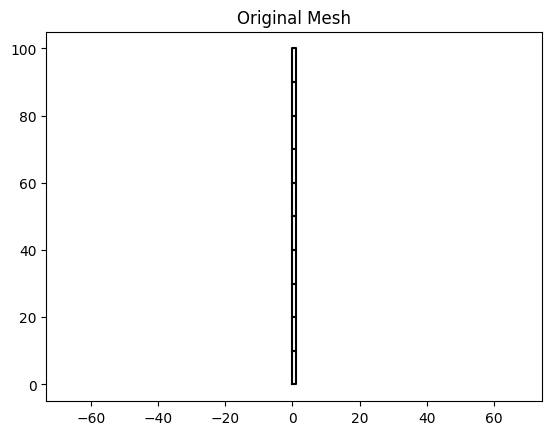

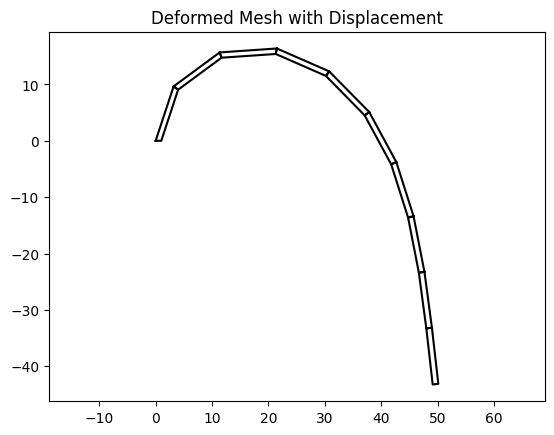

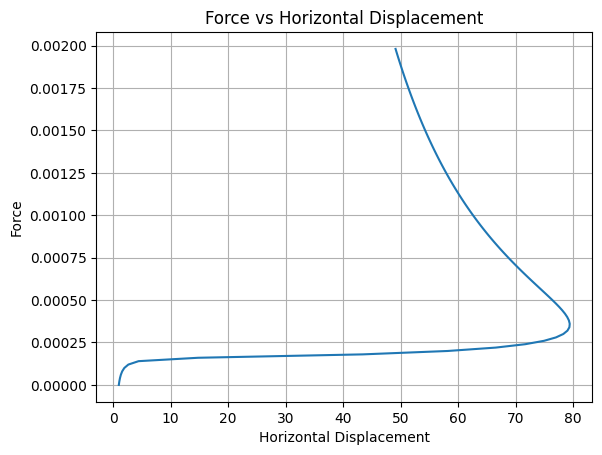

In [7]:
def drawmesh(nodes, elements, title=''):
    plt.figure()
    for elem in elements:
        pts = np.append(elem[:4], elem[0])  # Close the loop
        plt.plot(nodes[pts, 0], nodes[pts, 1], 'k-')
    plt.title(title)
    plt.axis('equal')
    plt.show()

# ====================== Visualization ======================          
drawmesh(nodes, elements, title='Original Mesh')
drawmesh(nodes_updated, elements, title='Deformed Mesh with Displacement')
plt.figure()
plt.plot(hori, np.arange(len(hori))/10*P0)
plt.xlabel('Horizontal Displacement')
plt.ylabel('Force')
plt.title('Force vs Horizontal Displacement')
plt.grid(True)
plt.show()